In [1]:
import pandas as pd

In [2]:
# Load the datasets
df1 = pd.read_excel("/content/Chungli_ao_Train.xlsx")

In [3]:
# Load the datasets
#df2 = pd.read_excel("/content/mizo_sentiment_dataset.xlsx")

In [4]:
df1.head()

,Text,Sentiment
0,Kohima nung nisung asem Tang tashi nung tashid...,POSITIVE
1,"asenok ajak semdangtsü imlaa Paisa, nüburtem d...",POSITIVE
2,Iba shisadokden senden nung atema senden nung ...,POSITIVE
3,Iba senden nung Chief menogo. Iba senden nung ...,POSITIVE
4,Iba senden nung 2021-22 atema V AC tasen ka as...,POSITIVE


In [5]:
# Concatenate the datasets
df = df1
#df = pd.concat([df1, df2])

In [6]:
# Display information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8579 entries, 0 to 8578
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       8579 non-null   object
 1   Sentiment  8579 non-null   object
dtypes: object(2)
memory usage: 134.2+ KB


In [7]:
# Converting the labels to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sentiment'] = le.fit_transform(df.Sentiment.values)

In [8]:
# Shuffle the dataframe
from sklearn.utils import shuffle
df = shuffle(df)

In [9]:
df

,Text,Sentiment
8544,"Talisa, ABAM Ordination Council dang iba Ordin...",1
4064,ajanga tweet ka nung ashi. Mitkartemi February...,0
5364,sorkar tenzükertemi kanga Iba film nung Dhanus...,1
7867,Magistrate-temi mapang shia Covid-19 temzüng d...,0
1335,bushisüngdangtsü atema reprangshitsü atema sor...,1
...,...,...
8002,"memetetdaktsü, saka tatalokbatem lai meteta al...",0
837,majungdang iba tesem nung yanglushitsü atema 2...,1
5620,dang metetdaktsü. dokan ajak nung hand wash ac...,1
1546,amenoka aliba The Northeast aliba The Sikkim C...,1


In [10]:
# Count the number of true and fake labels
Positive_labels = (df['Sentiment'] == 1).sum()
Negative_labels = (df['Sentiment'] == 0).sum()
print(f"Number of   Postive labels: {Positive_labels}")
print(f"Number of Negative labels: {Negative_labels}")

Number of   Postive labels: 4505
Number of Negative labels: 4074


In [11]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels_str, val_labels_str = train_test_split(list(df['Text']), list(df['Sentiment']), test_size=.2)

In [12]:
# Install required packages
!pip install sentencepiece
!pip install transformers
!pip install transformers accelerate
!pip install torch==1.11.00.676617

ERROR: Could not find a version that satisfies the requirement torch==1.11.00.676617 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch==1.11.00.676617


In [13]:
# Load tokenizer and model
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# Ensure all elements are strings
train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

In [15]:
# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [16]:
# Define custom dataset class
class spanish_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
# Encode labels
train_labels = le.fit_transform(train_labels_str)
val_labels = le.transform(val_labels_str)

# Create dataset objects
train_dataset = spanish_Dataset(train_encodings, train_labels)
val_dataset = spanish_Dataset(val_encodings, val_labels)

In [18]:
# additional classifocation layer on top of my model
import torch.nn as nn

#class CustomClassifier(nn.Module):
    #def __init__(self, model_name, num_labels):
     #   super(CustomClassifier, self).__init__()
      #  self.base_model = XLMRobertaModel.from_pretrained(model_name)
     #   self.dropout = nn.Dropout(0.3)
     #   self.classifier = nn.Linear(self.base_model.config.hidden_size, num_labels)

   # def forward(self, input_ids, attention_mask, labels=None):
    #    outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
    #    pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the representation of [CLS] token
     #   pooled_output = self.dropout(pooled_output)
     #   logits = self.classifier(pooled_output)

      #  loss = None
     #   if labels is not None:
        #    loss_fct = nn.CrossEntropyLoss()
        #    loss = loss_fct(logits.view(-1, 2), labels.view(-1))

       # return (loss, logits) if loss is not None else logits

In [19]:
class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomClassifier, self).__init__()
        self.base_model = XLMRobertaModel.from_pretrained(model_name)
        self.config = self.base_model.config  # Add this line
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the representation of [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [20]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

In [21]:
# Instantiate the custom model
model_name = 'xlm-roberta-base'
num_labels = 2  # Number of classes for classification
custom_model = CustomClassifier(model_name, num_labels)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [22]:
# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {'Accuracy': acc, 'F1': f1, 'Precision': precision, 'Recall': recall}

In [23]:
!pip install wandb
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


In [24]:
# Here, I initialized the weights & biases
wandb.init(project='Roboust_nlp_error_analysis', name='xlmr_error_analysis')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
import torch
torch.cuda.empty_cache()

In [26]:
# Define training arguments
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    learning_rate=0.0001,
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    do_eval=True,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=10,
    report_to='wandb',
)

# Initialize the Trainer
trainer = Trainer(
    model=custom_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # compute metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Train the model
trainer.train()

# Evaluate the model

metrics = trainer.evaluate()
print(metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.689900,0.689687,0.534965,0.534965,0.534965,0.534965
20,0.686800,0.686473,0.534965,0.534965,0.534965,0.534965
30,0.684200,0.681431,0.534965,0.534965,0.534965,0.534965
40,0.656600,0.643096,0.534965,0.534965,0.534965,0.534965
50,0.617800,0.607898,0.597319,0.597319,0.597319,0.597319
60,0.568300,0.497166,0.749417,0.749417,0.749417,0.749417
70,0.453900,0.337187,0.853730,0.853730,0.853730,0.853730
80,0.332000,0.306978,0.899184,0.899184,0.899184,0.899184
90,0.316400,0.297804,0.907925,0.907925,0.907925,0.907925
100,0.312800,0.293638,0.914918,0.914918,0.914918,0.914918


{'eval_loss': 0.2050383985042572, 'eval_Accuracy': 0.9487179487179487, 'eval_F1': 0.9487179487179487, 'eval_Precision': 0.9487179487179487, 'eval_Recall': 0.9487179487179487, 'eval_runtime': 14.5132, 'eval_samples_per_second': 118.238, 'eval_steps_per_second': 7.442, 'epoch': 3.0}


#Test_set

In [27]:
test_df = pd.read_excel("/content/Chungli_Ao_test.xlsx")

In [28]:
len(test_df)

2000

In [29]:
test_df.head()

,Text,Sentiment
0,tajungtiba nung anir. ATMA staff dang o tajung...,POSITIVE
1,Iba osang atema onok dang agitsüpur ajak iba t...,POSITIVE
2,ni iba tasen ba ya meimer,POSITIVE
3,Aba tasayaba ya ajak dang tajungtiba,POSITIVE
4,Tajitettsütem Symptoms: (tang tashi nung angaz...,POSITIVE


In [30]:
test_df.tail()

,Text,Sentiment
1995,parnok kong aliar mejangja; süadoker asü tepuo...,NEGATIVE
1996,Magadh Range nunga DIG inyakogo.Taoba mapang C...,NEGATIVE
1997,(FLWs) aser arishi küm 45 ser temapur nem vacc...,NEGATIVE
1998,"Director, Rev Atha Neikha ajanga sayatsü. Iba ...",NEGATIVE
1999,melenshija lir.Democracy busema longkak aitba ...,NEGATIVE


In [31]:
test_texts = list(test_df['Text'])

In [52]:
test_df['Sentiment'] = le.fit_transform(test_df.Sentiment.values)

In [33]:
test_labels = test_df['Sentiment']

In [34]:
len(test_labels)

2000

In [35]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = spanish_Dataset(test_encodings, test_labels)

In [36]:
test_metrics = trainer.evaluate(test_dataset)

In [37]:
print(test_metrics)

{'eval_loss': 0.6404132843017578, 'eval_Accuracy': 0.8275, 'eval_F1': 0.8275, 'eval_Precision': 0.8275, 'eval_Recall': 0.8275, 'eval_runtime': 16.8468, 'eval_samples_per_second': 118.717, 'eval_steps_per_second': 7.42, 'epoch': 3.0}


#Pushing_To_Hugging_face

In [38]:
from huggingface_hub import login

login()

In [43]:
from transformers import XLMRobertaForSequenceClassification

# Load the model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)  # Assuming binary classification
model.resize_token_embeddings(len(tokenizer))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(250002, 768, padding_idx=1)

In [44]:
model.save_pretrained("/content/results")
tokenizer.save_pretrained("/content/results")

('/content/results/tokenizer_config.json',
 '/content/results/special_tokens_map.json',
 '/content/results/sentencepiece.bpe.model',
 '/content/results/added_tokens.json')

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("/content/results")
model = AutoModelForSequenceClassification.from_pretrained("/content/results")

In [46]:
model.push_to_hub("Blue7Bird/Roboust_nlp_xlmr")
tokenizer.push_to_hub("Blue7Bird/Roboust_nlp_xlmr")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Blue7Bird/Roboust_nlp_xlmr/commit/c32b89aae0481a269dc42dc9945df2d58b686bf6', commit_message='Upload tokenizer', commit_description='', oid='c32b89aae0481a269dc42dc9945df2d58b686bf6', pr_url=None, pr_revision=None, pr_num=None)

#Error analysis

File saved as misclassified_ChungliAO_test.xlsx
Sentiment
Negative     21
Positive    324
dtype: int64


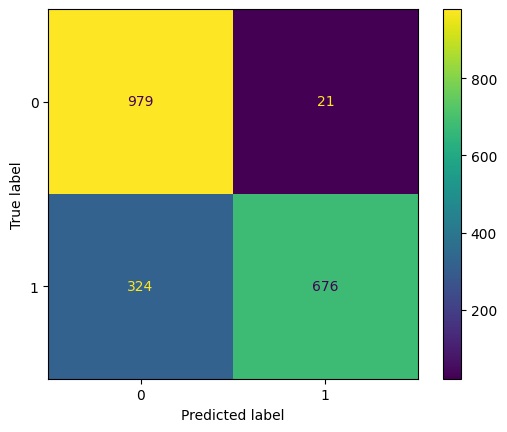

In [48]:
# Here I made the predictions on the test dataset using the trained model
test_predictions = trainer.predict(test_dataset)

# Here I converted the predictions into label indices by taking the argmax
pred_labels = test_predictions.predictions.argmax(-1)

# Here I assigned the predicted labels to a new column in the test dataframe
test_df['Predicted_Label'] = pred_labels

# Here I created a new column in the test dataframe that checks if the predicted label matches the true label
test_df['Correct'] = test_df['Sentiment'] == test_df['Predicted_Label']

# Here I filtered the dataframe to include only the rows where the prediction was incorrect
misclassified = test_df[test_df['Correct'] == False]

# Here I displayed the columns 'Claim', 'Label', and 'Predicted_Label' from the misclassified examples
misclassified[['Text', 'Sentiment', 'Predicted_Label']]

# Save the misclassified claims into a dataframe
misclassified_df = misclassified[['Text', 'Sentiment', 'Predicted_Label']]

file_path = 'misclassified_ChungliAO_test.xlsx'
misclassified_df.to_excel(file_path, index=False)

print(f"File saved as {file_path}")

# Here I created a confusion matrix of the test set based on the results of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['Sentiment'], test_df['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


# Here I wanted to see which labels are misclassified
category_errors = misclassified.groupby('Sentiment').size()
category_errors.index = category_errors.index.map({0: 'Negative', 1: 'Positive'})
print(category_errors)